In [79]:
import re
import random
import pandas as pd
import hashlib

In [80]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [81]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Windows PATH Variable,150.119017,5.003967,14.741386,30
Node.JS and React,790.647546,25.504760,35.906133,31
"Mexican Gothic, Moreno-Garcia",1107.633830,39.558351,66.475993,28
Azure Functions Core Tools,772.877805,45.463400,62.062018,17
Django,2540.350626,63.508766,84.519751,40
Node.js and Vite,2653.798115,64.726783,91.788875,41
Python,5653.783249,72.484401,184.342054,78
Azure Files Documentation,4580.919325,76.348655,163.107281,60
Active Directory and Azure Files,3040.492223,82.175465,126.028400,37
CCH Tax Forms Project,1772.022026,84.382001,153.678586,21


# Histogram

sum of ages: ~55496.76


<Axes: >

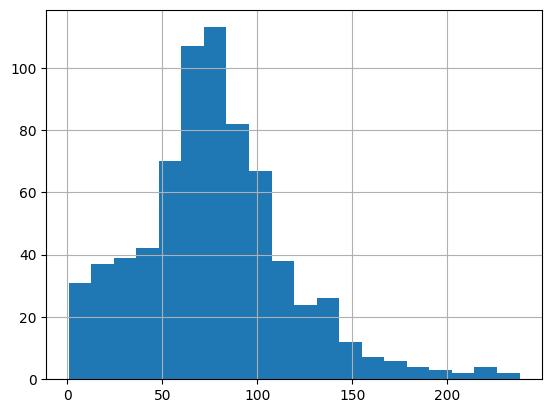

In [82]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~55496.76


<Axes: >

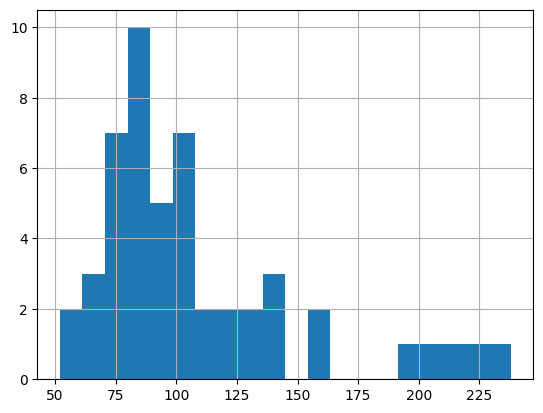

In [83]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='JavaScript Concepts']['age'].hist(bins=20)

# Completely Random Shuffle

In [84]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [85]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [86]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [87]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 716
Total card age: 55496.76


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
94,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,-237.989325,-108.413516,237.989325,5420.675783,0.357246,50,0,0
97,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,-200.866518,-108.413516,237.989325,5420.675783,0.357246,50,3,0
208,JavaScript Concepts,Front: Can you call functions within a string ...,4012807cd99ab5f95b268087a1f427ed,-159.587372,-108.413516,237.989325,5420.675783,0.357246,50,6,0
209,JavaScript Concepts,Front: What are the benefits of using callback...,f5bf95b4ed4b3d635d6bf3c63ea760ae,-136.529547,-108.413516,237.989325,5420.675783,0.357246,50,9,0
316,JavaScript Concepts,Front: How do you access the raw string conten...,33240fc1b83be7277bb131a00c5da765,-124.934089,-108.413516,237.989325,5420.675783,0.357246,50,12,0
409,JavaScript Concepts,A callback function is a function that is pass...,9e96d1dc94b7dd39126ee26cf8895d9b,-110.047723,-108.413516,237.989325,5420.675783,0.357246,50,15,0
411,JavaScript Concepts,Bracket Notation: You can also use bracket not...,961a8466fc666d52f999cd6c5124cbb9,-103.448725,-108.413516,237.989325,5420.675783,0.357246,50,18,0
481,JavaScript Concepts,Create N empty sub-arrays via Array.from\n le...,f409b7dd80d2dab8315877e467bde8f6,-100.648535,-108.413516,237.989325,5420.675783,0.357246,50,21,0
484,JavaScript Concepts,Promises: Objects representing the eventual co...,5f4d3efe8780f646899e998663742dbc,-94.622140,-108.413516,237.989325,5420.675783,0.357246,50,24,0
579,JavaScript Concepts,Use a private backing field for getter-only pr...,66e0e2b6634afd822c3f89f8fb08a058,-90.104662,-108.413516,237.989325,5420.675783,0.357246,50,27,0


## Age Max

In [88]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [89]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [90]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [91]:
existing_cards.head(10)['age'].sum()

np.float64(-1358.778634282192)

In [92]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
94,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,-237.989325,-108.413516,237.989325,5420.675783,0.357246,50,0,0
29,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,-228.728587,-102.468291,228.728587,2049.365824,0.005722,20,0,0
95,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,-225.100014,-108.413516,237.989325,5420.675783,0.357246,50,1,1
99,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,-222.733587,-87.202561,222.733587,4360.128060,0.726860,50,0,0
39,Vocab,"Something Rotten, Fforde\nSalver\nnoun | SAL-v...",c8d10134bc737eb530dfa3f6d3e44e00,-216.600877,-105.125730,216.600877,2312.766069,0.044043,22,0,0
96,JavaScript Concepts,Many operators coerce the operands into number...,c7910dc971abc5da390f0193c2ffbdc8,-214.874679,-108.413516,237.989325,5420.675783,0.357246,50,2,2
100,Microsoft Purview,Run the policy in simulation mode with notific...,3a95ac540d1e377383ba60aeb1da4f08,-208.903916,-87.202561,222.733587,4360.128060,0.726860,50,1,1
40,Vocab,"How to Sell a Haunted House, Hendrix\nStollen ...",2f0f1d406aece7f1fd77835411449718,-203.403653,-105.125730,216.600877,2312.766069,0.044043,22,1,1
97,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,-200.866518,-108.413516,237.989325,5420.675783,0.357246,50,3,0
98,JavaScript Concepts,Logical AND (&&) and OR (||) Statements\nif (c...,8541c9ae716e3f5474869ab92784fcc8,-198.104935,-108.413516,237.989325,5420.675783,0.357246,50,4,1


In [93]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 77.509'